* Descriptors
 * types
 * usage in python
* Metaclasses
* GIL and how to cope with it
* GC
* Weak references
* Unittesting

### Descriptors

In [ ]:
from sqlalchemy import Column, Integer, String

class User(Base):
    id = Column(Integer, primary_key=True)
    name = Column(String)

```
Дескриптор это атрибут объекта со “связанным поведением”, то есть такой атрибут, при доступе к которому его поведение переопределяется методом протокола дескриптора. Эти методы  __get__, __set__ и __delete__. Если хотя бы один из этих методов определен в объекте , то можно сказать что этот метод дескриптор."
Раймонд Хеттингер
```

* Получим значение атрибута, some_variable = obj.a 
* Изменим его значение, obj.a = 'new value'
* Удалим атрибут, del obj.a

Стандартный поиск атрибутов объекта:
`a.x` -> `a.__dict__['x']` -> `type(a).__dict__['x']` -> ... excluding metaclasses.

Python позволяет перехватить выше упомянутые попытки доступа к атрибуту и переопределить связанное с этим доступом поведение. Это реализуется через механизм протокола дескрипторов.

### Descriptor Protocol

`descr.__get__(self, obj, type=None) -> value`

`descr.__set__(self, obj, value) -> None`

`descr.__delete__(self, obj) -> None`

`descr.__set_name__(self, obj, name) -> None`
 * Вызывается во время создания класса. В этом случае дескриптор назначается на имя атрибута.


If an object defines `__set__()` or `__delete__()`, it is considered a data descriptor. 

Descriptors that only define `__get__()` are called non-data descriptors (they are typically used for methods but other uses are possible).

Дескрипторы данных и не данных отличаются в том, как будет изменено поведение поиска, если в словаре объекта уже есть запись с таким же именем как у дескриптора. Если попадается дескриптор данных, то он вызывается раньше, чем запись из словаря объекта. Если в такой же ситуации окажется дескриптор не данных, то запись из словаря объекта имеет преимущество перед этим дескриптором.

* дескрипторы вызываются с помощью метода `__getattribute__`
* переопределение `__getattribute__` прекратит автоматический вызов дескрипторов
* `object.__getattribute__` и `type.__getattribute__` делают разные вызовы к `__get__`
    * `b.x` -> `type(b).__dict__['x'].__get__(b, type(b))`
    * `B.x` -> `B.__dict__['x'].__get__(None, B)`
* дескрипторы данных всегда имеют преимущество перед переменными объекта
* дескрипторы не данных могут потерять преимущество из-за переменных объекта

In [23]:
class Order:
    price = NonNegative('price')  # (3)
    quantity = NonNegative('quantity')
    def __init__(self, name, price, quantity):
        self._name = name
        self.price = price
        self.quantity = quantity
    def total(self):
        return self.price * self.quantity

apple_order = Order('apple', 1, 10)
apple_order.total() # 10
apple_order.price = -10 # ValueError: Cannot be negative
apple_order.quantity = -10 # ValueError: Cannot be negative

ValueError: Cannot be negative.

In [ ]:
class NonNegative:
    def __init__(self, name):
        self.name = name  # (4)
    def __get__(self, instance, owner):
        return instance.__dict__[self.name]  # (5)
    def __set__(self, instance, value):
        if value < 0:
            raise ValueError('Cannot be negative.')
        instance.__dict__[self.name] = value  # (6)

Строка (4): атрибут name необходим при создание объекта NonNegative в строке (3), в данные момент еще не происходит изменения значения price. Таким образом, мы явно передаем имя атрибута price что бы использовать его как ключ при доступе к экземпляру `__dict__`.

Строки (5) и (6): вместо использования встроенный функций getattr и setattr, мы напрямую обращаемся к объекту __dict__ , что бы избежать ошибки  RecursionError, так как обращение через встроенные функции будут так же перехватываться протоколом дескрипторов.

### Python 3.6 `__set_name__`

In [25]:
class NonNegative:
    ...
    def __set_name__(self, owner, name):
        self.name = name

In [ ]:
class NonNegative:
    def __get__(self, instance, owner):
        return instance.__dict__[self.name]
    def __set__(self, instance, value):
        if value < 0:
            raise ValueError('Cannot be negative.')
        instance.__dict__[self.name] = value
    def __set_name__(self, owner, name):
        self.name = name
        
class Order:
    price = NonNegative()
    quantity = NonNegative()
    def __init__(self, name, price, quantity):
        self._name = name
        self.price = price
        self.quantity = quantity
    def total(self):
        return self.price * self.quantity
    
apple_order = Order('apple', 1, 10)
apple_order.total() # 10
apple_order.price = -10 # ValueError: Cannot be negative
apple_order.quantity = -10 # ValueError: Cannot be negative

### Descriptors examples

### Properties

property(fget=None, fset=None, fdel=None, doc=None) -> атрибут, реализующий свойства дескрипторa данных

`fget` is a function to be used for getting an attribute value, and likewise `fset` is a function for setting, and `fdel` a function for del'ing, an attribute. 

In [ ]:
class C(object):
    
    def getx(self): return self.__x
    def setx(self, value): self.__x = value
    def delx(self): del self.__x
    
    x = property(getx, setx, delx, "Я свойство 'x'.")

In [ ]:
class Property(object):
    "Эмуляция PyProperty_Type() в Objects/descrobject.c"
    def __init__(self, fget=None, fset=None, fdel=None, doc=None):
        self.fget = fget
        self.fset = fset
        self.fdel = fdel
        self.__doc__ = doc
        
    def __get__(self, obj, objtype=None):
        if obj is None:
            return self
        if self.fget is None:
            raise AttributeError, "can't read attr"
        return self.fget(obj)
    
    def __set__(self, obj, value):
        if self.fset is None:
            raise AttributeError, "can't set attr"
        self.fset(obj, value)
    
    def __delete__(self, obj):
        if self.fdel is None:
            raise AttributeError, "can't del attr"
        self.fdel(obj)

### Functions and Methods

Все объектно-ориентированные возможности реализованы с помощью функционального подхода. Сделанно это через дескрипторы.

Словари классов хранят методы в виде функций. При определении класса, методы записываются с помощью def и lambda — стандартных инструментов для создания функций. Единственное отличие этих функций от обычных в том, что первый аргумент зарезервирован под экземпляр объекта. -> `self`

Для того, чтобы поддерживать вызов методов, функции включают в себя метод `__get__`, который автоматически делает их дескрипторами не данных при поиске атрибутов. Функции возвращают связанные или не связанные методы, в зависимости от того, через что был вызван этот дескриптор.

In [ ]:
class Function(object):
    ...
    def __get__(self, obj, objtype=None):
        "Симуляция func_descr_get() в Objects/funcobject.c"
        return types.MethodType(self, obj, objtype)

In [40]:
class C:
    def a(self, b):
        return b

print(C.__dict__['a'])
print(C.a) # <unbound method D.f> in python2
print(type(C.a))
print(C().a)
print(type(C().a))
print(C().a.__func__)

<function C.a at 0x7fd5037d51e0>
<function C.a at 0x7fd5037d51e0>
<class 'function'>
<bound method C.a of <__main__.C object at 0x7fd503ac2ba8>>
<class 'method'>
<function C.a at 0x7fd5037d51e0>


In [43]:
class C:
    def a(self, b):
        return b

print(C().a.__func__)
print(C().a.__self__)
C().a.b = 1

<function C.a at 0x7fd5037d5950>


AttributeError: 'method' object has no attribute 'b'

* transformation from function object to instance method object happens each time the attribute is retrieved from the instance.

* transformation only happens for user-defined functions; other callable objects (and all non-callable objects) are retrieved without transformation. 

* user-defined functions which are attributes of a class instance are not converted to bound methods; this only happens when the function is an attribute of the class.

### Static Methods and Class Methods

Дескрипторы не данных предоставляют простой механизм для различных вариантов привязки функций к методам.

Функции имеют метод `__get__`, с помощью которых они становятся методами, во время поиска атрибутов и автоматического вызова дескрипторов. Дескрипторы не данных преобразуют вызов `obj.f(*args)` в вызов `f(obj, *args)`, а вызов `klass.f(*args)` становится `f(*args)`.

|Преобразование |	Вызвана через объект	 | Вызвана через класс|
|----------------:|-------------------------:|------------- |
Дескриптор  |	функция	f(obj, *args) |	f(*args)
staticmethod	|f(*args)	| f(*args)
classmethod	| f(type(obj), *args) |	f(klass, *args)

In [47]:
class ClassMethod:
    """Эмуляция PyClassMethod_Type() в Objects/funcobject.c"""
    
    def __init__(self, f):
        self.f = f

    def __get__(self, obj, klass=None):
        if klass is None:
            klass = type(obj)

        def newfunc(*args):
            return self.f(klass, *args)
        return newfunc


In [48]:
class StaticMethod:
    """Эмуляция PyStaticMethod_Type() в Objects/funcobject.c"""

    def __init__(self, f):
        self.f = f

    def __get__(self, obj, objtype=None):
        return self.f

## Metaclasses

In [50]:
class ObjectFactory:
    pass

print(type(ObjectFactory))
print(isinstance(ObjectFactory, object))

<class 'type'>
True


First class object:

* его можно присвоить переменной,
* его можно скопировать,
* можно добавить к нему атрибут,
* его можно передать функции в качестве аргумента,

### Create class on the fly

In [52]:
def choose_class(name):
    if name == 'foo':
        class Foo(object):
            pass
        return Foo # возвращает класс, а не экземпляр
    else:
        class Bar(object):
            pass
        return Bar
    
cls = choose_class('foo')
print(cls)
print(cls())

<class '__main__.choose_class.<locals>.Foo'>
<__main__.choose_class.<locals>.Foo object at 0x7fd5035ea198>


### `type()`

In [69]:
# type(object) -> the object's type
print(type(1))
print(type('1'))
print(type(type))
print(type(type(type.__class__)))

<class 'int'>
<class 'str'>
<class 'type'>
<class 'type'>


In [56]:
# type(name, bases, dict) -> a new type

MyFlyingClass = type('MyShinyClass', (), {})
print(MyFlyingClass)
print(MyFlyingClass())

<class '__main__.MyShinyClass'>


In [57]:
class Foo:
    bar = True

# тоже самое, что:

Foo = type('Foo', (), {'bar':True})

In [58]:
fobj = Foo()
fobj.bar

True

In [59]:
class FooChild(Foo):
    pass

fchild = FooChild()
fchild.bar

True

In [60]:
FlyingChild = type('FooChild', (Foo,), {})
print(FlyingChild)

<class '__main__.FooChild'>


In [67]:
def baz(self):
    print(self.bar)

PrintAndFlyFoo = type('PrintAndFlyFoo', (Foo,), {'baz': baz})

PrintAndFlyFoo().baz()

True


In [ ]:
class TimeStamper(object):
    """
    Add a timestamp to `event_dict`.
    """
    def __new__(cls, fmt=None, utc=True, key="timestamp"):
        if fmt is None and not utc:
            raise ValueError("UNIX timestamps are always UTC.")
            
        now_method = getattr(datetime.datetime, "utcnow" if utc else "now")
        
        if fmt is None:
            def stamper(self, _, __, event_dict):
                event_dict[key] = time.time()
                return event_dict
        elif fmt.upper() == "ISO":
            if utc:
                def stamper(self, _, __, event_dict):
                    event_dict[key] = now_method().isoformat() + "Z"
                    return event_dict
            else:
                def stamper(self, _, __, event_dict):
                    event_dict[key] = now_method().isoformat()
                    return event_dict
        else:
            def stamper(self, _, __, event_dict):
                event_dict[key] = now_method().strftime(fmt)
                return event_dict

        return type("TimeStamper", (object,), {"__call__": stamper})()

### So, about Metaclasses

The class creation process can be customized by passing the metaclass keyword argument in the class definition line, or by inheriting from an existing class that included such an argument. In the following example, both MyClass and MySubclass are instances of Meta

In [ ]:
class Meta(type):
    pass

class MyClass(metaclass=Meta):
    pass

class MySubclass(MyClass):
    pass

In [64]:
class Meta(type):
    pass

class MyClass:
    __metaclass__ = Meta
    pass

class MySubclass(MyClass):
    pass

In [65]:
class Meta(type):
    pass

__metaclass__ = Meta

class MyClass:
    pass

class MySubclass(MyClass):
    pass

When a class definition is executed, the following steps occur:

* MRO entries are resolved;
    * `__mro_entries__`
* the appropriate metaclass is determined;
    * if no bases and no explicit metaclass are given, then type() is used;

    * if an explicit metaclass is given and it is not an instance of type(), then it is used directly as the metaclass;

    * if an instance of type() is given as the explicit metaclass, or bases are defined, then the most derived metaclass is used.
* the class namespace is prepared;
    * If the metaclass has a `__prepare__` attribute, it is called as `namespace = metaclass.__prepare__(name, bases, **kwds)`

* the class body is executed;
    * ~`exec(body, globals(), namespace)`
* the class object is created.
    * `metaclass(name, bases, namespace, **kwds)`

### Custom Metaclasses

In [68]:
class Foo:
     pass

f = Foo()

* The `__call__` method of Foo’s parent class is called. `type.__call__`
* That `__call__` method in turn invokes the following:

    * `__new__`
    * `__init__`

In [71]:
def new(cls):
    x = object.__new__(cls)
    x.attr = 100
    return x

Foo.__new__ = new
f = Foo()
f.attr

100

In [72]:
class Meta(type):
    def __new __(cls, name, bases, dct):
        x = super().__new__(cls, name, bases, dct)
        x.attr = 100
        return x

class FooMeta(metaclass=Meta):
    pass

FooMeta.attr

100

In [73]:
class Boo(FooMeta):
    pass

Boo.attr

100

### `__new__` and `__init__`

In [ ]:
class MetaOne(type):
    def __new__(cls, name, bases, dict):
        pass

class MetaTwo(type):
    def __init__(self, name, bases, dict):
        pass

### Metaclass `__call__` method

According to the official docs, we can also override other class methods by defining a custom __call__() method in the metaclass that allows custom behavior when the class is called.

### Metaclass `__prepare__` method

```
Once the appropriate metaclass has been identified, then the class namespace is prepared. If the metaclass has a __prepare__ attribute, it is called as namespace = metaclass.__prepare__(name, bases, **kwds) (where the additional keyword arguments, if any, come from the class definition). If the metaclass has no __prepare__attribute, then the class namespace is initialized as an empty ordered mapping.
```

### Django ORM based on metaclasses

In [ ]:
class Person(models.Model):
    name = models.CharField(max_length=30)
    age = models.IntegerField()

### Singleton Design using a Metaclass

In [ ]:
class SingletonMeta(type):
    _instances = {}
    def __call__(cls, *args, **kwargs):
        if cls not in cls._instances:
            cls._instances[cls] = super(SingletonMeta,cls).__call__(*args, **kwargs)
        return cls._instances[cls]

class SingletonClass(metaclass=SingletonMeta):
    pass

### Зачем нам нужны метклассы ?
Вообще обычно они нам не нужны..

```
Метаклассы это глубокая магия, о которой 99% пользователей даже не нужно задумываться. Если вы думаете, нужно ли вам их использовать — вам не нужно (люди, которым они реально нужны, точно знают, зачем они им, и не нуждаются в объяснениях, почему).
~ Гуру Питона Тим Питерс
```

## GIL - Global Interpreter Lock

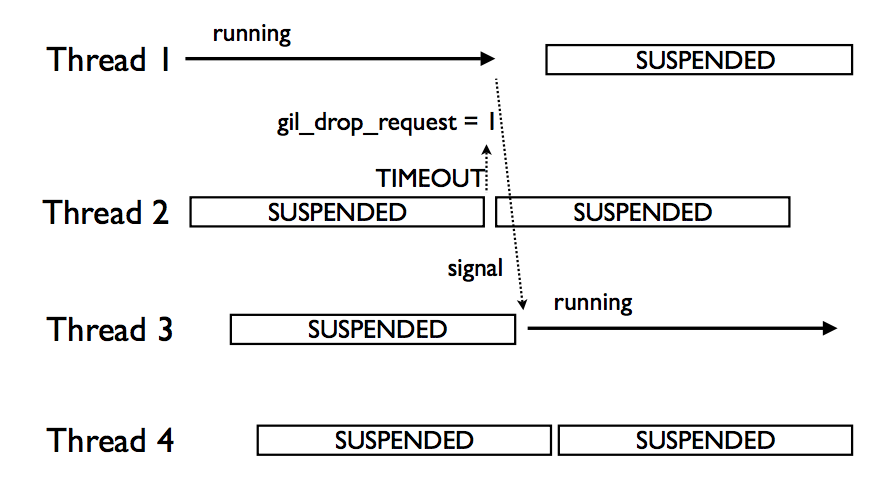

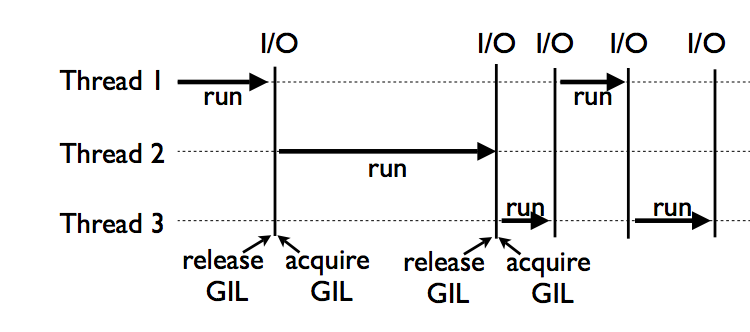

GIL — эта одиночный блокиратор самого интерпретатора Python. Он добавляет правило: любое выполнение байткода в Python требует блокировки интерпретатора.

GIL является самым простым способом избежать конфликтов при одновременном обращении разных потоков к одним и тем же участкам памяти. Когда один поток захватывает его, GIL, работая по принципу мьютекса, блокирует остальные. Нет параллельных потоков — нет конфликтов при обращении к разделяемым объектам. Очерёдность выполнения потоков определяет интерпретатор в зависимости от реализации, переключение между потоками может происходить: когда активный поток пытается осуществить ввод-вывод, по исчерпании лимита выполненных инструкций либо по таймеру

In [1]:
import sys
a = []
b = a
sys.getrefcount(a)

3

#### Why GIL?

* GIL is fast, if we talk about single-thread
* It is faster in the multi-threaded case for cpu-bound programs that do their compute-intensive work in C libraries.
* It makes C extensions easier to write:
* It makes wrapping C libraries easier. You don't have to worry about thread-safety. If the library is not thread-safe, you simply keep the GIL locked while you call it.

### Reviewing terminology

* processes and threads are independent sequences of execution. 
* difference is that
    * threads (of the same process) run in a shared memory space
    * processes run in separate memory spaces.

In [7]:
# single_threaded.py
import time
# from threading import Thread

COUNT = 50000000

def countdown(n):
    while n > 0:
        n -= 1

start = time.time()
countdown(COUNT)
end = time.time()

print('Spend time: ', end - start)

Spend time:  2.411329746246338


In [4]:
# multi_threaded.py
import time
from threading import Thread

COUNT = 50000000

def countdown(n):
    while n > 0:
        n -= 1

t1 = Thread(target=countdown, args=(COUNT//2,))
t2 = Thread(target=countdown, args=(COUNT//2,))

start = time.time()
t1.start()
t2.start()
t1.join()
t2.join()
end = time.time()

print('Spend time: ', end - start)

Spend time:  2.1961309909820557


До python3.2 переключение происходит по количеству выполненных инструкций. Время выполнения инструкций может сильно отличаться (сравните простое сложение и создание списка на миллион элементов).

In [10]:
import sys
# По умолчанию интервал выставлен в 100
sys.getcheckinterval() 

/home/andrey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: sys.getcheckinterval() and sys.setcheckinterval() are deprecated.  Use sys.getswitchinterval() instead.
  This is separate from the ipykernel package so we can avoid doing imports until


100

In [13]:
def f(lst, val):
    return [i for i in lst if i != val]


dis.dis(f)

  2           0 LOAD_CLOSURE             0 (val)
              2 BUILD_TUPLE              1
              4 LOAD_CONST               1 (<code object <listcomp> at 0x7f3c485a35d0, file "<ipython-input-13-55cc1ac5f898>", line 2>)
              6 LOAD_CONST               2 ('f.<locals>.<listcomp>')
              8 MAKE_FUNCTION            8
             10 LOAD_FAST                0 (lst)
             12 GET_ITER
             14 CALL_FUNCTION            1
             16 RETURN_VALUE

Disassembly of <code object <listcomp> at 0x7f3c485a35d0, file "<ipython-input-13-55cc1ac5f898>", line 2>:
  2           0 BUILD_LIST               0
              2 LOAD_FAST                0 (.0)
        >>    4 FOR_ITER                16 (to 22)
              6 STORE_FAST               1 (i)
              8 LOAD_FAST                1 (i)
             10 LOAD_DEREF               0 (val)
             12 COMPARE_OP               3 (!=)
             14 POP_JUMP_IF_FALSE        4
             16 LOAD_FAST     

In [14]:
sys.getswitchinterval()

0.005

* поток, владеющий GIL, не отдает его пока об этом не попросят.
* если уж отдал по просьбе, то подождет окончания переключения и не будет сразу же пытаться захватить GIL назад.
* поток, у которого сразу не получилось захватить GIL, сначала выждет 5 мс и лишь потом пошлет запрос на переключение, принуждая текущего владельца освободить ценный ресурс. Таким образом переключение осуществляется не чаще чем раз в 5 мс, если только владелец не отдаст GIL добровольно перед выполнением системного вызова.

### Как справиться c GIL

In [15]:
from multiprocessing import Pool
import time

COUNT = 50000000

def countdown(n):
    while n > 0:
        n -= 1

if __name__ == '__main__':
    pool = Pool(processes=2)
    start = time.time()
    r1 = pool.apply_async(countdown, [COUNT//2])
    r2 = pool.apply_async(countdown, [COUNT//2])
    pool.close()
    pool.join()
    end = time.time()
    print('Spend time: ', end - start)

Spend time:  1.414212703704834


#### Альтернативные интерпретаторы Python. 
У Python есть много разных реализаций интерпретаторов. CPython, Jyton, IronPython и PyPy, написанные на C, Java, C# и Python соответственно. GIL существует только на оригинальном интерпретаторе — на CPython.

### Для IO операций GIL не страшен

All of Python's blocking I/O primitives release the GIL while waiting for the I/O block to resolve

In [ ]:
import threading
import requests

urls = [...]

def worker():
    while True:
        try:
            url = urls.pop()
        except IndexError:
            break  # Done.

        requests.get(url)

for _ in range(10):
    t = threading.Thread(target=worker)
    t.start()
    
# Or using asyncio

Or you can write C/C++ extensions using Python API

* https://docs.python.org/3/c-api/init.html

### Garbage collection

#### Менеджер памяти

* Python не освобождает всю память обратно операционной системе как только он удаляет какой либо объект
* использует дополнительный менеджер памяти, предназначенный для маленьких объектов (размер которых меньше чем 512 байт)
* Для работы с такими объектами он выделяет большие блоки памяти, в которых в дальнейшем будет хранится множество маленьких объектов.
* если блок пуст - может вернуть его ОС
* долгоживущее приложение может начать потреблять много памяти

#### Два алгоритма сборки мусора
* подсчет ссылок
* generational garbage collector

#### Подсчет ссылок
* не может быть отключен
* каждый объект содержит поле - счетчик ссылок на него
* если счетчик равен 0 -> объект уничтажается

In [18]:
foo = []

# 2 ссылки, одна от переменной foo и одна от getrefcount
print(sys.getrefcount(foo))

def bar(a):
    # 4 ссылки
    # от foo, аргумента функции (a), getrefcount и одна от стека вызова функции
    print(sys.getrefcount(a))

bar(foo)
# 2 ссылки, локальные ссылки внутри функции уничтожены
print(sys.getrefcount(foo))

2
4
2


### generational garbage collector

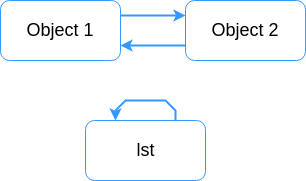

In [20]:
import gc
import ctypes

# используется ctypes для доступа к объектам по адресу памяти
class PyObject(ctypes.Structure):
    _fields_ = [("refcnt", ctypes.c_long)]

gc.disable()  # выключаем циклический GC
lst = []
lst.append(lst)

# сохраняем адрес списка lst
lst_address = id(lst)

# удаляем ссылку lst
del lst

object_1 = {}
object_2 = {}
object_1['obj2'] = object_2
object_2['obj1'] = object_1

obj_address = id(object_1)

# удаляем ссылки
del object_1, object_2
# раскомментируйте для запуска ручной сборки объектов с циклическими ссылками
# gc.collect()

# проверяем счетчик ссылок
print(PyObject.from_address(obj_address).refcnt)
print(PyObject.from_address(lst_address).refcnt)

1
1


* циклический GC не работает в режиме реального времени и запускается периодически
* разделяет все объекты на 3 поколения
    * Новые объекты попадают в первое поколение.
    * Переживший сборку новый объект попадает в второе поколение 
    * Аналогично.
* Чем выше поколение, тем режи идет сборка мусора
* У каждого поколения есть счетчик и порог срабатывания, когда нужно запустить сборку
* Стандартные пороги срабатывания для поколений установлены на 700, 10 и 10
* gc следит только за container objects arrays, dictionaries, user class instances
* GC игнорирует tuples содержащие только неизменяемые типы

In [23]:
import gc

#gc.set_threshold()
gc.get_threshold()

(700, 10, 10)

### как работает алгоритм поиска циклов:
* https://github.com/python/cpython/blob/v3.7.0/Modules/gcmodule.c#L796

```
GC итерирует каждый объект из выбранных поколений и временно удаляет все ссылки от отдельно взятого объекта (все ссылки на которые этот объект ссылается). После полного прохода, все объекты, у которых счетчик ссылок меньше двух считаются недоступными из питона и могут быть удалены.

```

### Weak References in python

В программировании слабая ссылка (англ. weak reference) — специфический вид ссылок на динамически создаваемые объекты в системах со сборкой мусора или с подсчётом ссылок. Отличается от строгих ссылок тем, что сборщик мусора не учитывает связь ссылки и объекта в куче при выявлении объектов, подлежащих удалению. Таким образом слабая ссылка позволяет работать с объектом как и строгая ссылка, но при необходимости объект будет удален, даже при наличии слабой ссылки на него. Обычные ссылки в контексте сборки мусора иногда именуют «сильными».

You would use weak references for expensive objects, or to avoid circle references (although the garbage collector usually does it on its own).

A primary use for weak references is to implement caches or mappings holding large objects, where it’s desired that a large object not be kept alive solely because it appears in a cache or mapping.

In [28]:
import weakref
import sys
import gc


class MyObject(object):
    def my_method(self):
        print('my_method was called!')

obj = MyObject()
r = weakref.ref(obj)
print(type(r))

gc.collect()
assert r() is obj # r() allows you to access the object referenced: it's there.

obj = 1 # Let's change what obj references to
gc.collect()

assert r() is None # There is no object left: it was gc'ed.

<class 'weakref'>


### Shallow and Deep copy

* A __shallow copy__ means constructing a new collection object and then populating it with references to the child objects found in the original. In essence, a shallow copy is only one level deep. The copying process does not recurse and therefore won’t create copies of the child objects themselves.
* A __deep copy__ makes the copying process recursive. It means first constructing a new collection object and then recursively populating it with copies of the child objects found in the original. Copying an object this way walks the whole object tree to create a fully independent clone of the original object and all of its children.

In [32]:
xs = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]

ys = list(xs)

xs == ys

True

In [33]:
xs.append(['new sublist'])
print(xs)
print(ys)

[[1, 2, 3], [4, 5, 6], [7, 8, 9], ['new sublist']]
[[1, 2, 3], [4, 5, 6], [7, 8, 9]]


In [34]:
xs[1][0] = 'X'

print(xs)
print(ys)

[[1, 2, 3], ['X', 5, 6], [7, 8, 9], ['new sublist']]
[[1, 2, 3], ['X', 5, 6], [7, 8, 9]]


In [35]:
import copy
xs = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
zs = copy.deepcopy(xs)

In [37]:
xs[1][0] = 'X'

print(xs)
print(zs)

[[1, 2, 3], ['X', 5, 6], [7, 8, 9]]
[[1, 2, 3], [4, 5, 6], [7, 8, 9]]


### Тестирование и отладка 

### Unit Tests vs. Integration Tests

* Unit testing is a practice to make sure that the function or module which you are going to implement is going to behave as expected (requirements) and also to make sure how it behaves in scenarios like boundary conditions, and invalid input.
* A unit test checks a small component in your application.
____
* Testing multiple components is known as integration testing
* An integration test checks that components in your application operate with each other.



### Asserts

* Inform developers what your code expects.
* Inform the computer what your code expects.
* Inform the readers of your code (including yourself) what your code has achieved at some point.
* Inform the computer what your code has achieved at some point.

In [39]:
def raise_if_not_one(argument):
    assert argument == 1, 'argument is not equal to one'
 
raise_if_not_one(0)

AssertionError: argument is not equal to one

* не информативно
* можно выключить `python -O file.py`

### unittesting

OOP concepts supported by unittest framework:


* test fixture:
        A test fixture is used as a baseline for running tests to ensure that there is a fixed environment in which tests are run so that results are repeatable.
        Examples :
    * creating temporary databases.
    * starting a server process.
* test case:
        A test case is a set of conditions which is used to determine whether a system under test works correctly.
* test suite:
        Test suite is a collection of testcases that are used to test a software program to show that it has some specified set of behaviours by executing the aggregated tests together.
* test runner:
        A test runner is a component which set up the execution of tests and provides the outcome to the user.

In [43]:
import unittest 
  
class SimpleTest(unittest.TestCase): 
  
    # Returns True or False.  
    def test(self):         
        self.assertTrue(True) 


# customize tests run to be able to do so in jupyter

unittest.main(argv=['first-arg-is-ignored'], exit=False)

.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


Outcomes Possible :

There are three types of possible test outcomes :

* OK – This means that all the tests are passed.
* FAIL – This means that the test did not pass and an AssertionError exception is raised.
* ERROR – This means that the test raises an exception other than AssertionError.

In [53]:
import unittest 
  
class TestStringMethods(unittest.TestCase): 
    def setUp(self): 
        self.user = 'John', 'smith'
    
    def test_strings_a(self): # Returns True if the string contains 4 a. 
        self.assertEqual( 'a'*4, 'aaaa') 
     
    def test_upper(self): # Returns True if the string is in upper case.         
        self.assertEqual(self.user[0].upper(), 'JOHN') 
    
    def test_isupper(self): # Returns TRUE if the string is in uppercase else returns False.       
        self.assertTrue('FOO'.isupper()) 
        self.assertFalse('Foo'.isupper()) 
      
    def test_strip(self): #Returns true if the string is stripped and matches the given output.        
        s = 'waitingforhomework'
        self.assertEqual(s.strip('waiting'), 'forhomework') 
     
    def test_split(self): # Returns true if the string splits and matches the given output.        
        s = 'hello world'
        self.assertEqual(s.split(), ['hello', 'world']) 
        with self.assertRaises(TypeError): 
            s.split(2) 

In [54]:
unittest.main(argv=['first-arg-is-ignored'], exit=False, verbosity=3)

test (__main__.SimpleTest) ... ok
test_isupper (__main__.TestStringMethods) ... ok
test_split (__main__.TestStringMethods) ... ok
test_strings_a (__main__.TestStringMethods) ... ok
test_strip (__main__.TestStringMethods) ... ok
test_upper (__main__.TestStringMethods) ... ok

----------------------------------------------------------------------
Ran 6 tests in 0.009s

OK


### HomeWork

In [ ]:
Реализовать такой метакласс, что экземпляры класса созданного с помощью него
будут удовлетворять следующим требованиям:

* объекты созданные с одинаковыми аттрибутами будут одним и тем же объектом
* объекты созданные с разными аттрибутами будут разными объектами
* у любого объекта есть мозможность получить доступ к другим объектам
    того же класса


>>> unit1 = SiamObj('1', '2', a=1)
>>> unit2 = SiamObj('1', '2', a=1)
>>> unit1 is unit2
True
>>> unit3 = SiamObj('2', '2', a=1)
>>> unit3.connect('1', '2', 1).a = 2
>>> unit2.a == 2
True
>>> pool = unit3.pool
>>> print(len(pool))
2
>>> del unit3
>>> print(len(pool))
1

In [ ]:
"""
Написать свое property c кэшем и таймаутом
полностью повторяет поведение стандартной property за исключением:
    * хранит результат работы метода некоторое время, которое передается
      параметром в инициализацию проперти
    * пересчитывает значение, если таймер истек

"""
import time
import uuid


class Message:
    @timer_property(t=10) # sec
    def msg(self):
        self._msg = self.get_message()
        return self._msg

    @msg.setter # reset timer also
    def msg(self, param):
        self._msg = param

    def get_message(self):
        """
        Return random string
        """
        return uuid.uuid4().get_hex()

if __name__ == '__main__':
    m = Message()
    initial = m.read
    assert initial is m.read
    time.sleep(10)
    assert initial is not m.read


Написать тесты (pytest or unittest) к предыдущим 2 заданиям, запустив которые, я бы смог бы проверить их корректность
